# **Welcome to the World of Pacman again!! But this time in a python gym environment** (https://www.gymlibrary.ml/)

---



**Install the following libraries in your colab notebook to set up the environment**

In [104]:
%pip install -U gym==0.25.2
%pip install -U gym[atari,accept-rom-license]
! apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
! pip install imageio==2.4.1
! pip install -U colabgymrender

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import random


class ReplayBuffer(object):
    ''' TO LOAD DATA BATCH'''
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, buffer):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = buffer
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



Added during project:

In [106]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
import torch.nn.functional as F
from torch import flatten
from torchvision.transforms import Grayscale
from torch.optim import Adam

In [107]:
# source: https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
# activation layers removed because of https://towardsdatascience.com/automating-pac-man-with-deep-q-learning-an-implementation-in-tensorflow-ca08e9891d9c
class DQN(Module):
  def __init__(self, num_frames, num_actions):
    # constructor of
    super(DQN, self).__init__()
    # initialize first set of CONV => RELU => POOL layers
    self.conv1 = Conv2d(in_channels=num_frames, out_channels=16,  
      kernel_size=(5, 5))
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) 
    # initialize second set of CONV => RELU => POOL layers
    self.conv2 = Conv2d(in_channels=16, out_channels=40,
      kernel_size=(5, 5)) #kernel_size may need adaption
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) 
    # initialize first set of FC => RELU layers
    self.fc1 = Linear(in_features=15640, out_features=40)
    # initialize second set of FC => RELU layers
    self.fc2 = Linear(in_features=40, out_features=num_actions)

# Here, the forward-propagation is defined by applying the layers defined in the constructor
  def forward(self, x):
    # cast to float because conv1 method expects float values
    x = x/255.0
    # pass the input through our first set of CONV => RELU =>
    # POOL layers
    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)
    # pass the output from the previous layer through the second
    # set of CONV => RELU => POOL layers
    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)
    # flatten the output from the previous layer and pass it
    # through our first set of FC => RELU layers
    x = torch.flatten(x, start_dim = 0)
    x = F.relu(self.fc1(x))
    # pass the output to our softmax classifier to get our output
    # predictions
    x = self.fc2(x)
    output = x
    # return the output predictions
    return output
  



In [109]:
import gym
from colabgymrender.recorder import Recorder
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.optim as optim
from torch import nn

import torch.nn.functional as F
'''
IMPORT NECESSARY DL LIBRARIES e.g torch, tensorflow,etc.
Be careful to change the numpy arrays to tensors wherever required
'''



class Pacman:
    """
        :param gamma: reward discount
        :param batch_size: replay buffer batch sizes
        :param env: gym environment
        :param num_frames: number of frames per state (and number per action)
    """
    def __init__(self, gamma=.95, batch_size=64,
                env='MsPacmanDeterministic-v4', num_frames=4):
        '''
        Code HERE to
        Modify wherever needed
        '''
        self.num_frames = num_frames
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #SPECIFY TRAINING DEVICE to use GPU e.g torch.device('cuda'), tf.device('/device:GPU:0') to train faster 
        self.memory = ReplayBuffer(50000)
        self.gamma = gamma
        self.eps = 0.1
        self.batch_size = batch_size
        self.score_history = []
        self.env = gym.make(env)
        self.start = self.get_init_frame()
        _, height, width = len(self.start[0]),len(self.start[1]),len(self.start[2])
        self.num_actions = self.env.action_space.n
        self.policy = DQN(num_frames, self.num_actions).to(self.device)
        self.target = DQN(num_frames, self.num_actions).to(self.device)
        self.loss = nn.MSELoss()
        self.opt = Adam(self.policy.parameters(), lr=.001, eps=self.eps) # maybe change learning rate


    def get_init_frame(self):
        self.lives = 3
        frame = self.preprocess(self.env.reset())
        frames = []
        for i in range(self.num_frames):
            frames.append(frame)
        return np.array(frames)

    def preprocess(self, img):
        ds = img[::2,::2]
        grayscale = np.mean(ds, axis=-1).astype(np.uint8)
        return np.expand_dims(grayscale, axis=0)

    def fit_model(self, sample):
        policy = self.policy
        target = self.target
        dev = self.device # USE THE GPU DEVICE TO TRAIN FASTER
        loss=0.0

        states, actions, next_states, rewards, non_terms = list(zip(*sample))
   
        # convert to torch-tensors for backpropagation
        states = (torch.tensor(np.concatenate(states))[:,:,0,:,:]).to(dev)
        actions = torch.tensor(actions).to(dev)
        next_states = (torch.tensor(np.concatenate(next_states))[:,:,0,:,:]).to(dev)
        rewards = torch.tensor(rewards).to(dev)
        
        target_q_next = torch.stack([target(state) for state in next_states])        
        target_q_next = target_q_next * self.gamma + torch.stack((rewards, rewards, rewards, rewards,rewards, rewards, rewards, rewards, rewards), 1) #Bellman-Equation
            
        policy_q = torch.stack([policy(state) for state in states])
        policy_q = policy_q.type(torch.FloatTensor)
      
        #initialize gradient
        self.opt.zero_grad()

        # Calculate & back-propagate loss
        loss = self.loss(policy_q, target_q_next) 
        loss.backward()

        # optimize according to loss calculated above (update weights)
        self.opt.step()

        return loss


    def choose_best_action(self, frames):
        #best_action=self.env.action_space.sample()#THIS IS A Sample action

        '''
        Your Code HERE
        USE DQN MODEL TO predict best_action
        you may would also like to define a eplison 
        to explore options other than best action with some probability
        '''   
        
        # take best known action if random value > epsilon
        if np.random.random() > self.eps:
          # remove color channel and add batch size/channel
          state = (torch.tensor(frames).squeeze(1)).unsqueeze(0).to(self.device)
          actions = self.policy(state)
          best_action = torch.argmax(actions).item()
        # otherwise choose random action 
        else:
          best_action = self.env.action_space.sample()
        return best_action

    def q_iteration(self, frames, iteration):
        env = self.env
        action = self.choose_best_action(frames)
        is_done = False
        new_frames = []
        total_reward = 0
        total_score = 0
        # Play one game iteration:
        for i in range(self.num_frames):
            if not is_done:
                new_frame, reward, is_done, lives = self.env.step(action)
                lives = lives['lives']
                new_frame = self.preprocess(new_frame)
                total_score += reward
                if lives < self.lives:
                    self.lives = lives
                total_reward += reward
            else:
                reward = 0
            new_frames.append(new_frame)

        non_term = 1
        if is_done:
            non_term = 0

        mem = (np.expand_dims(np.array(frames), axis=0), action,
               np.expand_dims(np.array(new_frames), axis=0), total_reward, non_term)
        self.memory.push(mem)

        loss = None
        # Sample and fit
        if iteration > 64:
            batch = self.memory.sample(self.batch_size)
            loss = self.fit_model(batch)

        return is_done, total_reward, new_frames, loss

    def train(self, epochs=10000, start_iter=0, updates=500):
        self.score_history = []
        self.loss_hist = []
        self.updates = updates
        self.its_hist = []
        iteration = start_iter
        running_loss = 0
        running_count = 0
        running_score = 0
        running_its = 0
        for e in range(epochs):
            is_done = False
            e_reward = 0
            e_its = 0
            frames = self.get_init_frame()
            while not is_done:
                is_done, reward, frames, loss = self.q_iteration(frames, iteration)
                iteration += 1
                e_reward += reward
                e_its += 1
                if loss is not None:
                    running_loss += loss.detach().numpy()
                    running_count += 1
            running_score += e_reward
            running_its += e_its
            
            #if e%10 == 0:
            if e%1 == 0:
                era_score = running_score / 10
                era_its = running_its / 10
                self.score_history.append(era_score)
                self.loss_hist.append(running_loss / running_count)
                self.its_hist.append(era_its)
                print(f'---> Epoch {e}/{epochs}, Score: {era_score}')
                print(f'-------->Loss: {running_loss / running_count}, Its: {era_its}')
                running_loss = 0
                running_count = 0
                running_score = 0
                running_its = 0
            
            
            


In [110]:
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np

pacman = Pacman()
pacman.train(3)

---> Epoch 0/3, Score: 88.0
-------->Loss: 407.9543820996828, Its: 14.4
---> Epoch 1/3, Score: 58.0
-------->Loss: 1076.0518727047752, Its: 13.1
---> Epoch 2/3, Score: 79.0
-------->Loss: 523.2417173506338, Its: 15.8


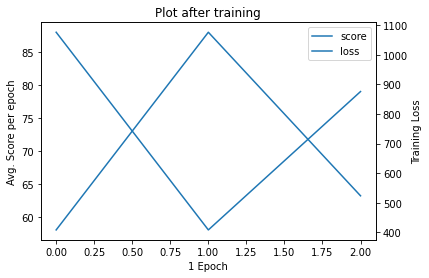

In [111]:
def plot(pacman):
  '''
  YOUR CODE HERE
  Define a plotting function here to visualize 
  the training loss and avg score per epoch
  '''
  fig, ax_score = plt.subplots()
  plt.title('Plot after training')
  ax_score.set_xlabel('1 Epoch')
  ax_score.set_ylabel('Avg. Score per epoch')
  ax_loss = ax_score.twinx()
  ax_loss.set_ylabel('Training Loss')
  x = range(len(pacman.score_history))
  p_score = ax_score.plot(x, pacman.score_history, label='score')
  p_loss = ax_loss.plot(x, pacman.loss_hist, label='loss')
  plots = p_score + p_loss
  labels = [plot.get_label() for plot in plots]
  ax_score.legend(plots, labels)
  plt.show()
  return 

plot(pacman)

In [112]:
pacman.env = Recorder(pacman.env, "./video")

state = pacman.get_init_frame()
is_done = False
while not is_done:
    action = pacman.choose_best_action(state)
    new_state = []
    for i in range(20):
        new_frame, reward, is_done, lives = pacman.env.step(action)
        if is_done:
            break

In [113]:
pacman.env.play()